Notebook corresponding to section 2.3.1 on the UKE dataset.

Imports

In [ ]:
# Local dependencies
from NET_CUP.data_loading.feature_type import FeatureType
from NET_CUP.data_loading import data_tree, xyp
from NET_CUP.utils import general_utils
import NET_CUP.datasources_config as datasources_config

# Other dependencies
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np

Settings

In [2]:
# Adjust these settings
feature_type = FeatureType.RETCCL
classifier = SVC(kernel='rbf')

# Keep these settings
pca = PCA(0.95)
patches_per_patient = 100
patch_size = 4096
border_patches = True

Load data

In [3]:
data = data_tree.create_tree(datasources_config.PATIENTS_PATH,
                             datasources_config.ENUMBER_PATH)
data_tree.drop_slides_without_extracted_features(data, feature_type, datasources_config.UKE_DATASET_DIR)
patients = data_tree.get_patients(data, 'pi')

Classifier training and testing

In [4]:
y_true_patient_level_complete = []
y_pred_patient_level_complete = []

y_true_patch_level_complete = []
y_pred_patch_level_complete = []

In [5]:
for test_patient in tqdm(patients): # Patient level LOO
    # Get training and testing data
    X_train_patch_level, y_train_patch_level, _ = xyp.get_patch_level_Xyp_complete([patient for patient in patients if patient != test_patient], patches_per_patient, feature_type, patch_size, border_patches, datasources_config.UKE_DATASET_DIR)
    X_test_patch_level, y_test_patch_level, _ = xyp.get_patch_level_Xyp_complete([test_patient], patches_per_patient, feature_type, patch_size, border_patches, datasources_config.UKE_DATASET_DIR)

    y_true_patch_level_complete.extend(y_test_patch_level)
    y_true_patient_level_complete.extend(xyp.get_patient_level_y([test_patient]))

    # Train patch classifier
    X_train_patch_level = pca.fit_transform(X_train_patch_level)
    classifier.fit(X_train_patch_level, y_train_patch_level)

    # Classify patches
    X_test_patch_level = pca.transform(X_test_patch_level)
    y_pred_patch_level = classifier.predict(X_test_patch_level)

    y_pred_patch_level_complete.extend(y_pred_patch_level)
    
    # Patient level inference by majority vote
    y_pred_patient_level = np.argmax(np.bincount(y_pred_patch_level))
    y_pred_patient_level_complete.append(y_pred_patient_level)
    

100%|██████████| 91/91 [30:11<00:00, 19.91s/it]


Patch level evaluation

Patch level accuracy: 0.8265934065934066


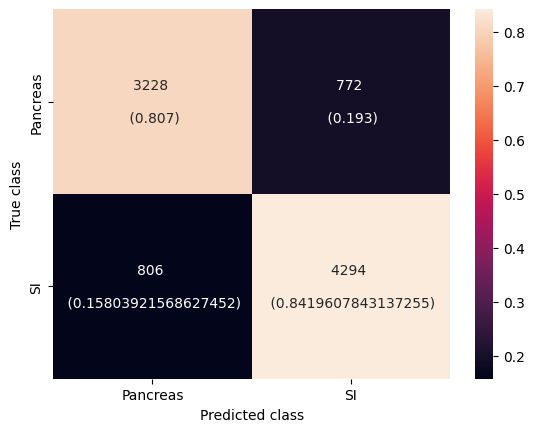

In [6]:
patch_level_accuracy = accuracy_score(y_true_patch_level_complete, y_pred_patch_level_complete)
print(f'Patch level accuracy: {patch_level_accuracy}')

patch_level_confusion_matrix = general_utils.confusion_matrix(y_true_patch_level_complete, y_pred_patch_level_complete, ['Pancreas', 'SI'])


Patient level evaluation

Patient level accuracy: 0.9340659340659341


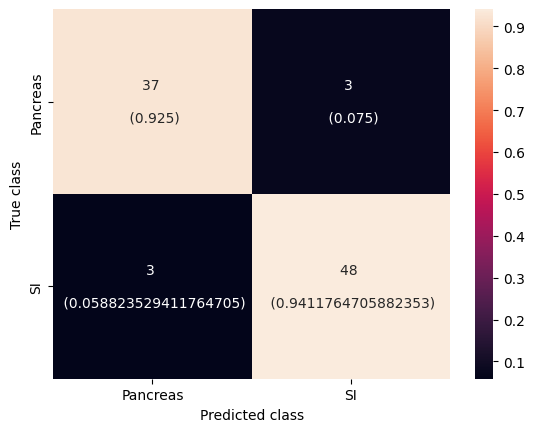

In [7]:
patient_level_accuracy = accuracy_score(y_true_patient_level_complete, y_pred_patient_level_complete)
print(f'Patient level accuracy: {patient_level_accuracy}')

patient_level_confusion_matrix = general_utils.confusion_matrix(y_true_patient_level_complete, y_pred_patient_level_complete, ['Pancreas', 'SI'])